In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text
import xgboost as xgb

In [2]:
df = pd.read_csv('housing.csv')

## Data Preparation

In [3]:
df = df[df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]
df = df.fillna(0)
df['ocean_proximity'] = df['ocean_proximity'].str.replace('<', '')

In [4]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)
y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

train_dict = df_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')
test_dict = df_test.to_dict(orient='records')
dv = DictVectorizer(sparse=True)
dv.fit(train_dict)
X_train = dv.transform(train_dict)
X_val = dv.transform(val_dict)

## Q1

In [12]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- ocean_proximity=1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=1H OCEAN >  0.50
|   |--- value: [12.30]



## Q2

In [13]:
rf = RandomForestRegressor(n_estimators=10, random_state=1,n_jobs=-1)
rf.fit(X_train, y_train)


RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [14]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [15]:
y_pred = rf.predict(X_val)

In [16]:
round(rmse(y_val, y_pred),3)

0.245

## Q3

In [17]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1,n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    score = round(rmse(y_val, y_pred),3)
    
    scores.append((n, score))

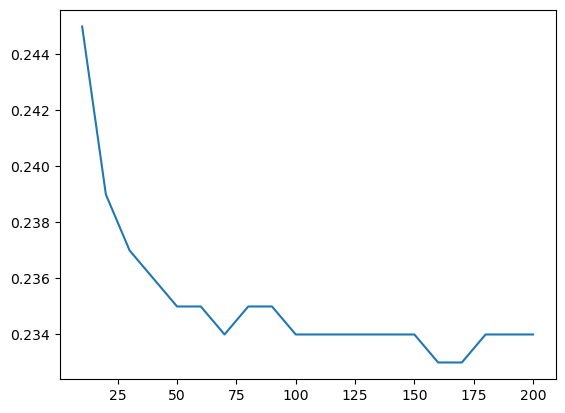

In [18]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])
plt.plot(df_scores.n_estimators, df_scores.rmse)

## Q4

In [19]:
scores = []

for d in [10,15,20,25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, random_state=1,n_jobs=-1, max_depth=d)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = round(rmse(y_val, y_pred),3)

        scores.append((d, n, score))

In [20]:
columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

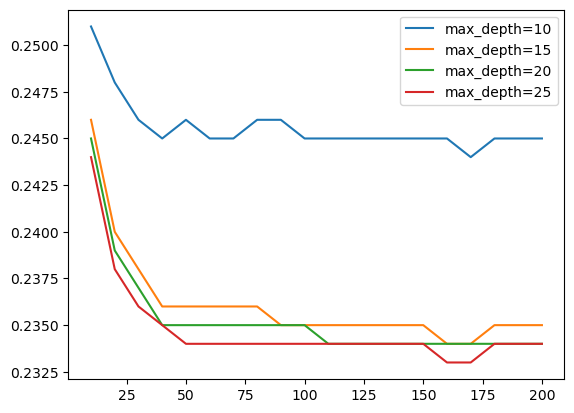

In [21]:
for d in [10,15,20,25]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse,
             label='max_depth=%d' % d)

plt.legend()

## Q5

In [22]:
rf = RandomForestRegressor(n_estimators=10, random_state=1,max_depth=20,n_jobs=-1)
rf.fit(X_train, y_train)
importances = rf.feature_importances_
feature_names = list(dv.get_feature_names_out())
feature_importance_dict = dict(zip(feature_names, importances))
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")

median_income: 0.33561112799548903
ocean_proximity=1H OCEAN: 0.29247296545343093
latitude: 0.10200703165624685
longitude: 0.08624381391950157
ocean_proximity=INLAND: 0.07380644294558006
housing_median_age: 0.030317256108796153
population: 0.027136059019747173
total_rooms: 0.021416985559250513
total_bedrooms: 0.015852218895139155
households: 0.01513609844681855


## Q6

In [9]:
features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100)

In [10]:
y_pred = model.predict(dval)

In [8]:
round(rmse(y_val, y_pred),3)

0.229

In [11]:
round(rmse(y_val, y_pred),3)

0.232